In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_csv('/content/sample_data/online_retail.csv', encoding='ISO-8859-1')

In [5]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<Axes: title={'center': 'Top-Selling Products'}, ylabel='Description'>

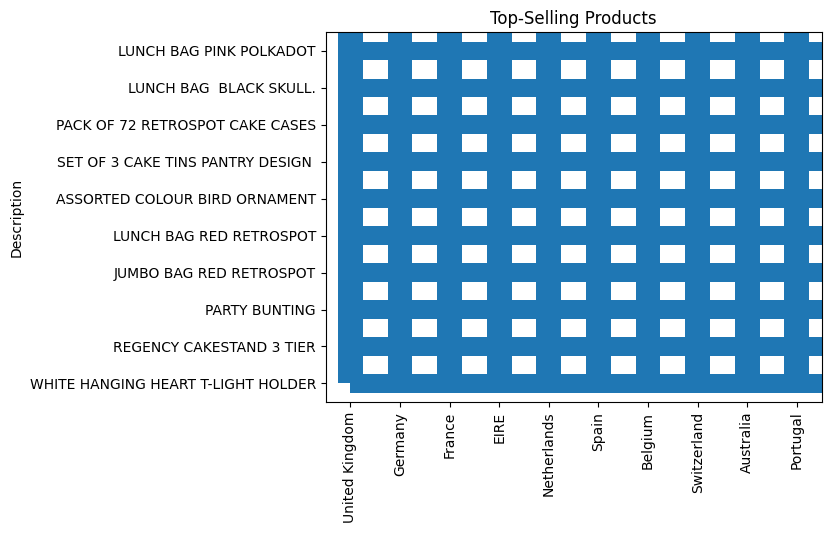

In [6]:
# Top 10 countries by transaction
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', title='Top 10 Countries by Transaction Count')

# Top products
df['Description'].value_counts().head(10).plot(kind='barh', title='Top-Selling Products')

In [7]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle

X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Save models
pickle.dump(kmeans, open("rfm_kmeans_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))


In [10]:
pivot_table = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
from sklearn.metrics.pairwise import cosine_similarity

item_similarity = cosine_similarity(pivot_table.T)
item_sim_df = pd.DataFrame(item_similarity, index=pivot_table.columns, columns=pivot_table.columns)

# Save similarity matrix
pickle.dump(item_sim_df, open("product_similarity.pkl", "wb"))